<a href="https://colab.research.google.com/github/Jef-H/Best-README-Template/blob/master/First_Pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Analysis of TESS Exoplanet Candidates


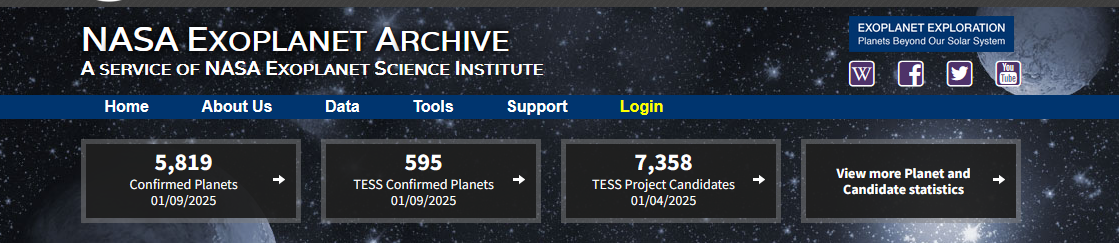


Transiting Exoplanet Survey Satellite (TESS) targets nearby stars, and looks for exoplanets that orbit those stars. The exoplanet candidates found can often be confirmed/studied by ground based telescopes or other space observatories.

for more info on TESS https://exoplanetarchive.ipac.caltech.edu/index.html


## Unsupervised Learning

This notebook explores unsupervised learning techniques to analyze the TESS exoplanet dataset and look for interesting clusters.

1. **Data Preprocessing**: Preparing the dataset by cleaning, scaling, and handling non-numeric features.
2. **Clustering Analysis**: Comparing multiple clustering algorithms.
      *   K-Means
      *   DBScan
      *   Gaussian Mixture


3. **Scoring the clusters**: Using silhouette score and Davies-Bouldin index to assess clustering results.


In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Read in the Planet Candidate clean dataset.
url = 'https://raw.githubusercontent.com/Jef-H/unsupervised_exoplanets/develop/TESS_project_candidates_clean.csv'
df = pd.read_csv(url)
# drop identification columns
df = df.drop(columns=['toipfx', 'toi'])
fig_count = 1


In [3]:
df.describe()

pl_orbper      pl_rade       pl_insol      st_tmag       st_dist  \
count  7256.000000  6874.000000    7202.000000  7358.000000   7147.000000   
mean     17.993210    10.324896    2254.521765    11.527877    475.692040   
std      98.481552     8.655134   10719.704497     1.637732    566.010695   
min       0.152076     0.552507       0.000342     4.627800      6.531270   
25%       2.460728     4.399826      85.967076    10.359500    176.400500   
50%       4.078383    10.504180     365.852081    11.781250    360.072000   
75%       7.906320    14.045700    1174.535000    12.837675    642.938000   
max    1837.889731   297.111726  280833.000000    18.332400  14728.300000   

            st_teff      st_logg       st_rad  
count   7214.000000  6542.000000  6874.000000  
mean    5798.666507     4.305184     1.407948  
std     1500.071273     0.305602     1.629440  
min     2808.000000     0.100000     0.114827  
25%     5205.850000     4.123918     0.890000  
50%     5801.500000     4.330000     1.240000  
75%     6303.650000     4.500000     1.660810  
max    50000.000000     5.960650   102.030000

In [4]:
print(df.dtypes)

tfopwg_disp     object
pl_orbper      float64
pl_rade        float64
pl_insol       float64
st_tmag        float64
st_dist        float64
st_teff        float64
st_logg        float64
st_rad         float64
dtype: object


Column Data Types:
 tfopwg_disp     object
pl_orbper      float64
pl_rade        float64
pl_insol       float64
st_tmag        float64
st_dist        float64
st_teff        float64
st_logg        float64
st_rad         float64
dtype: object
Non-Numeric Columns: Index(['tfopwg_disp'], dtype='object')
Missing values after removing non-numeric columns: pl_orbper    102
pl_rade      484
pl_insol     156
st_tmag        0
st_dist      211
st_teff      144
st_logg      816
st_rad       484
dtype: int64


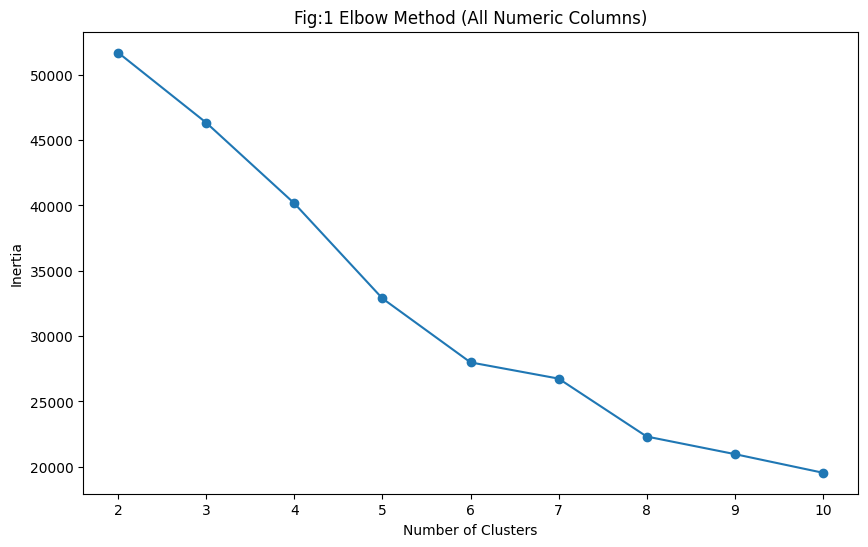

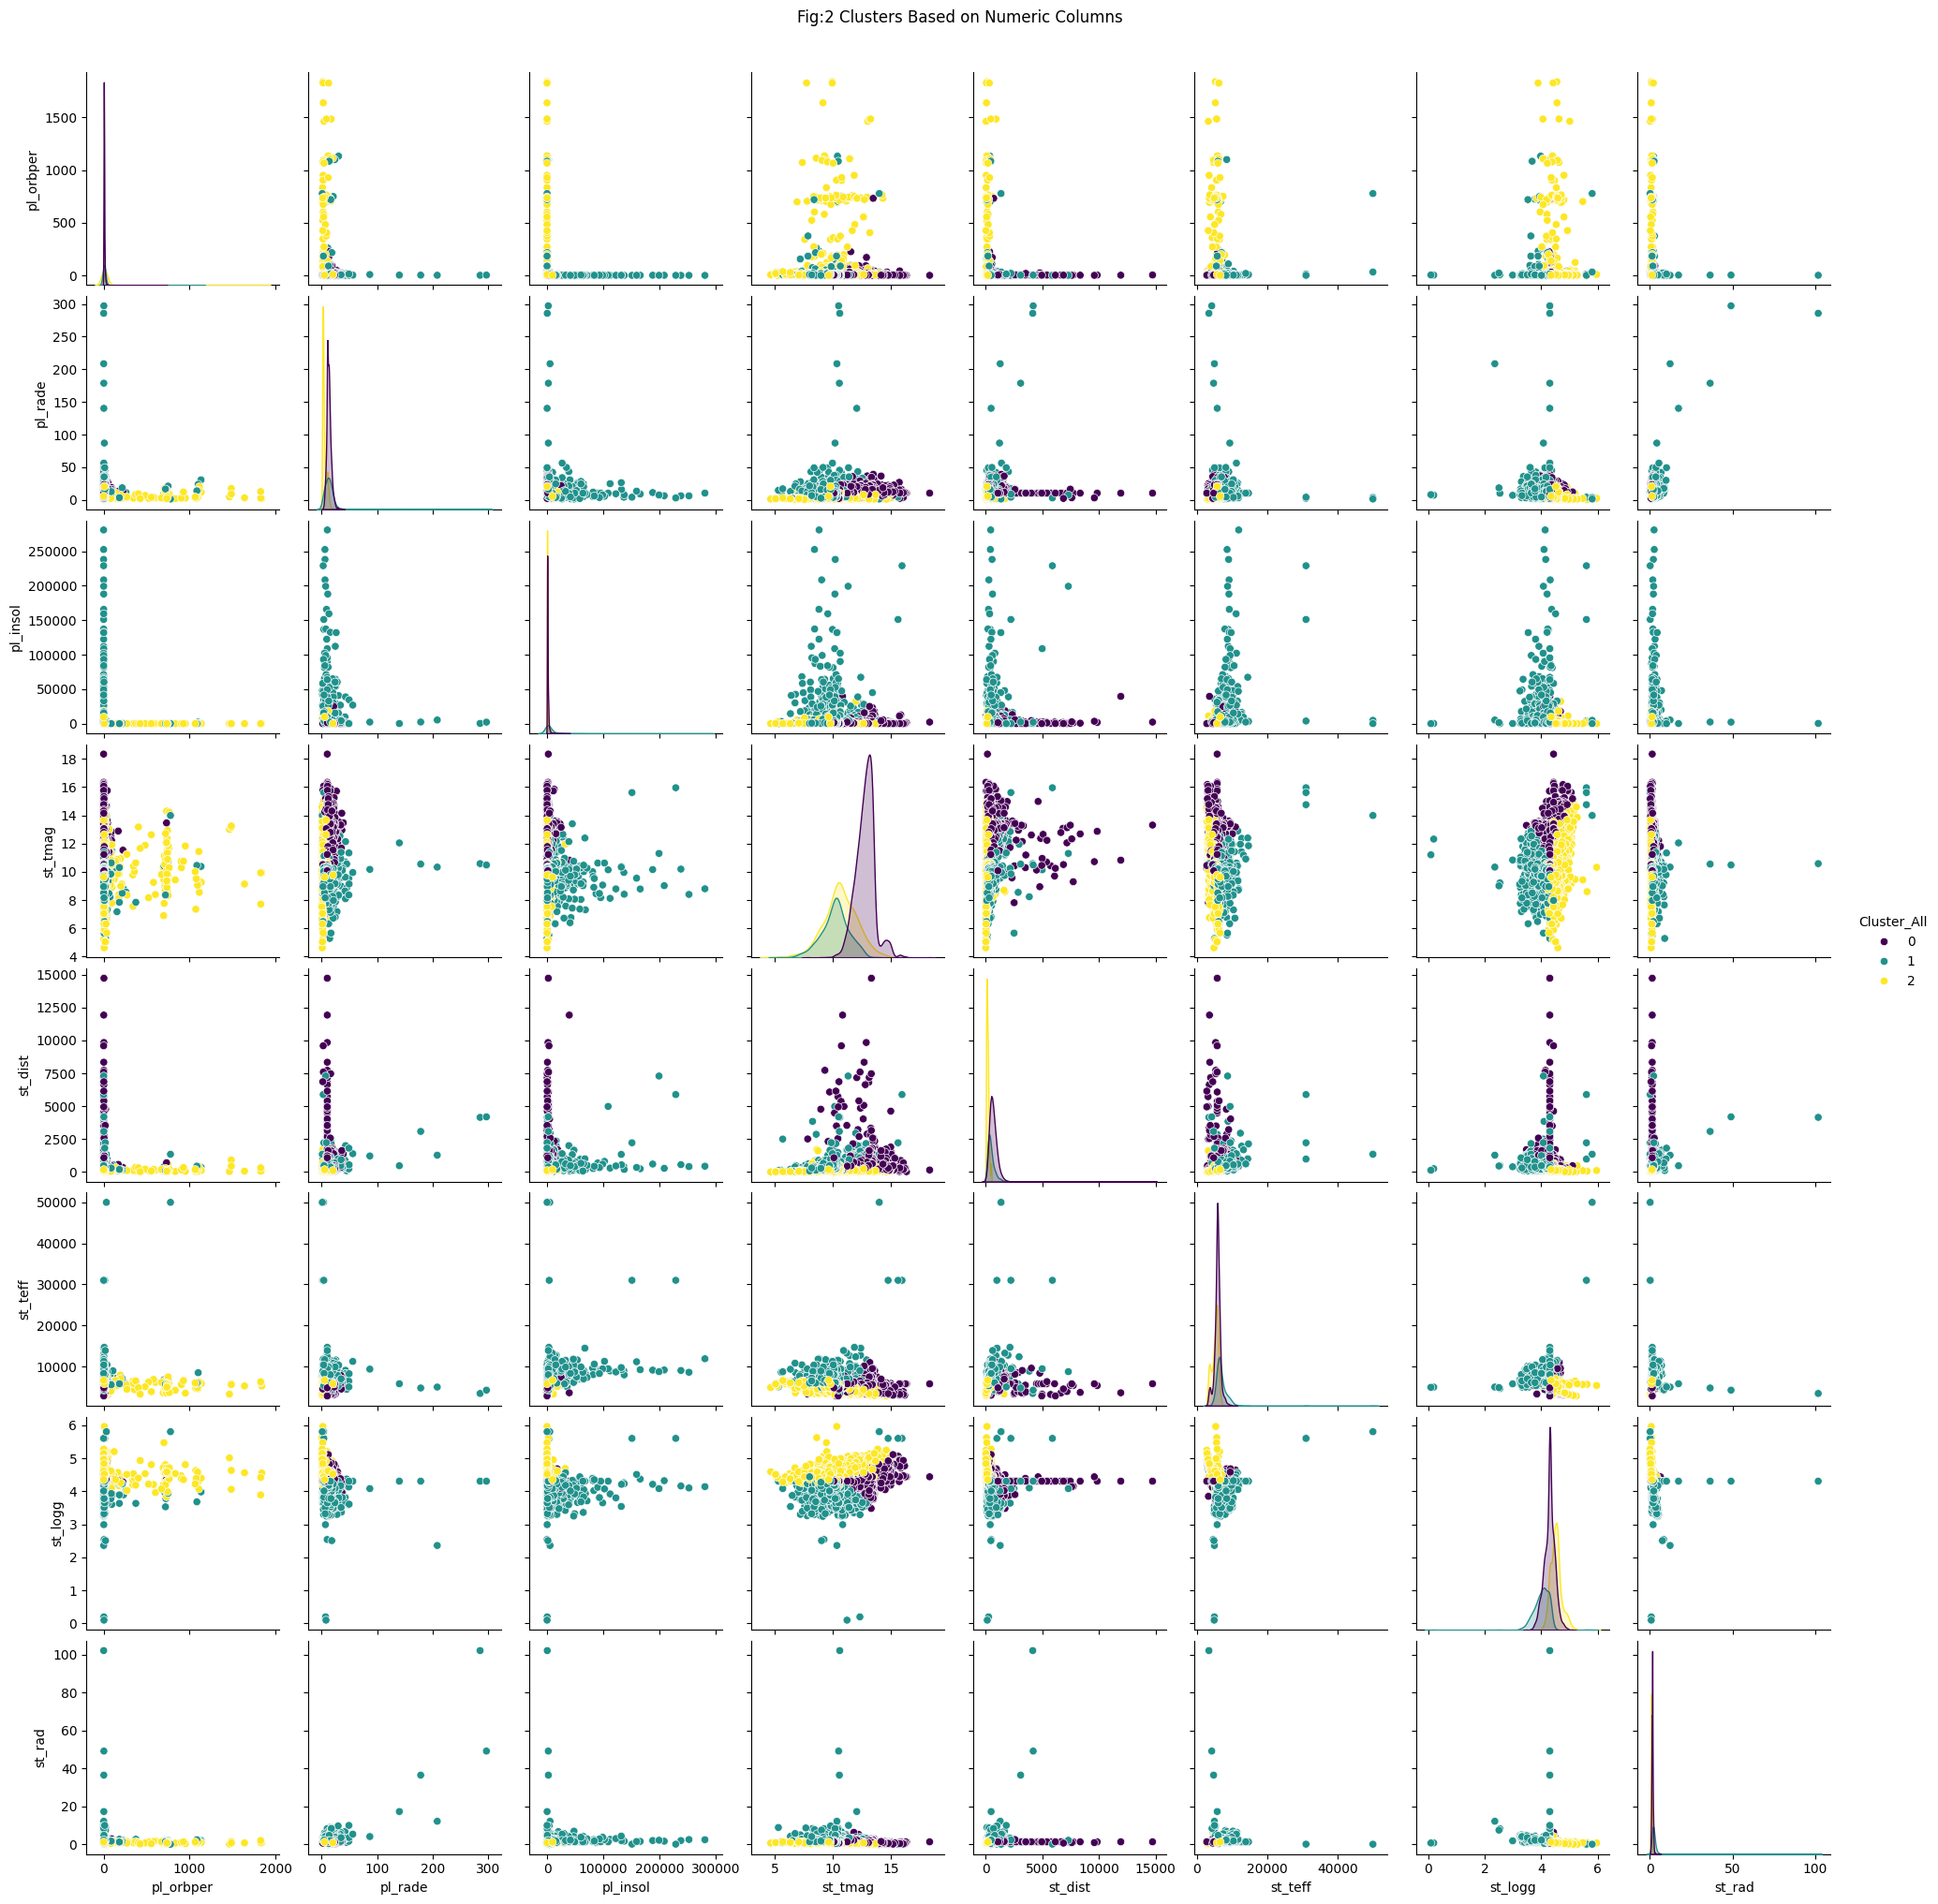

Cluster Sizes (All Numeric Columns):
 Cluster_All
0    3445
2    2419
1    1494
Name: count, dtype: int64


In [18]:
# Check the types of all columns to find the non-numeric ones
print("Column Data Types:\n", df.dtypes)

# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
print("Non-Numeric Columns:", non_numeric_columns)

# Handle non-numeric columns
# Option 1: Remove non-numeric columns (if they are irrelevant for clustering)
df.drop(columns=non_numeric_columns, inplace=True)

#from sklearn.preprocessing import LabelEncoder

#if 'tfopwg_disp' in df.columns:
#    le = LabelEncoder()
#    df['tfopwg_disp_encoded'] = le.fit_transform(df['tfopwg_disp'].astype(str))

# Check again for missing values after handling non-numeric columns
print("Missing values after removing non-numeric columns:", df.isna().sum())

# Fill missing values in the numeric columns
df.fillna(df.mean(), inplace=True)

# Now proceed with scaling the data
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
columns_to_scale = numeric_columns.drop('tfopwg_disp', errors='ignore')  # Avoid scaling the original categorical column

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[columns_to_scale])

# K-means clustering (Elbow method)
inertia = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title("Fig:" + str(fig_count) + " Elbow Method (All Numeric Columns)")
fig_count += 1
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Proceed with final clustering
kmeans_all = KMeans(n_clusters=3, random_state=42)
df['Cluster_All'] = kmeans_all.fit_predict(scaled_data)

# Visualizing clusters
sns.pairplot(df, vars=columns_to_scale, hue='Cluster_All', palette='viridis', diag_kind='kde')
plt.suptitle("Fig:" + str(fig_count) +" Clusters Based on Numeric Columns", y=1.02)
fig_count += 1
plt.show()

# Summary of cluster sizes
print("Cluster Sizes (All Numeric Columns):\n", df['Cluster_All'].value_counts())

# Save the clustered DataFrame
df.to_csv('clustered_data.csv', index=False)

In [6]:
# Reusable Cell: Evaluate Clustering Performance
from sklearn.metrics import silhouette_score, davies_bouldin_score

def score_clusters(cluster_labels, scaled_data):
  # Ensure that clustering labels are available
  # Compute Silhouette Score
  silhouette_avg = silhouette_score(scaled_data, cluster_labels)
  print(f"Silhouette Score: {silhouette_avg:.4f}")

  # Compute Davies-Bouldin Index
  davies_bouldin = davies_bouldin_score(scaled_data, cluster_labels)
  print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

  # Interpretation tips
  if silhouette_avg > 0.5:
      print("Silhouette Score indicates good separation between clusters.")
  elif 0.2 <= silhouette_avg <= 0.5:
      print("Silhouette Score indicates moderate separation between clusters.")
  else:
      print("Silhouette Score indicates poor separation between clusters.")

  if davies_bouldin < 1:
      print("Davies-Bouldin Index indicates well-formed clusters.")
  else:
      print("Davies-Bouldin Index suggests room for improvement in cluster quality.")

score_clusters(kmeans_all.labels_, scaled_data)

Silhouette Score: 0.2432
Davies-Bouldin Index: 1.5556
Silhouette Score indicates moderate separation between clusters.
Davies-Bouldin Index suggests room for improvement in cluster quality.


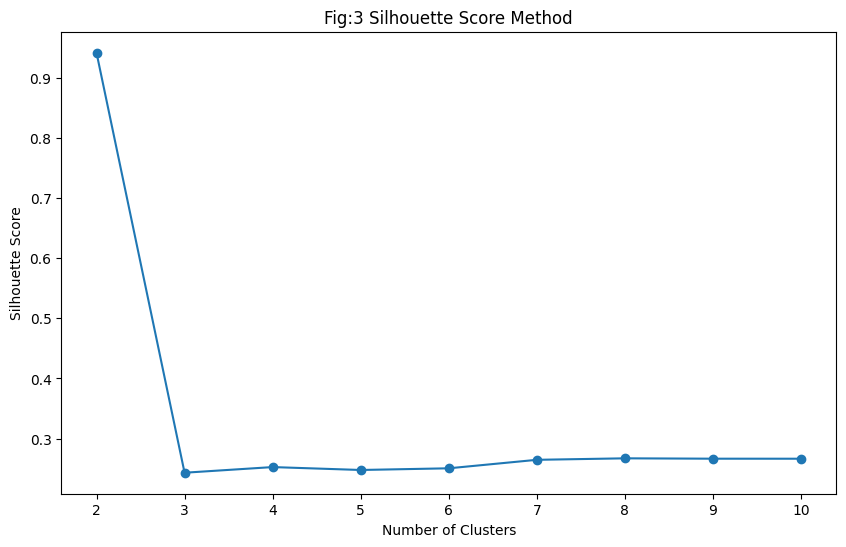

The optimal number of clusters is: 2


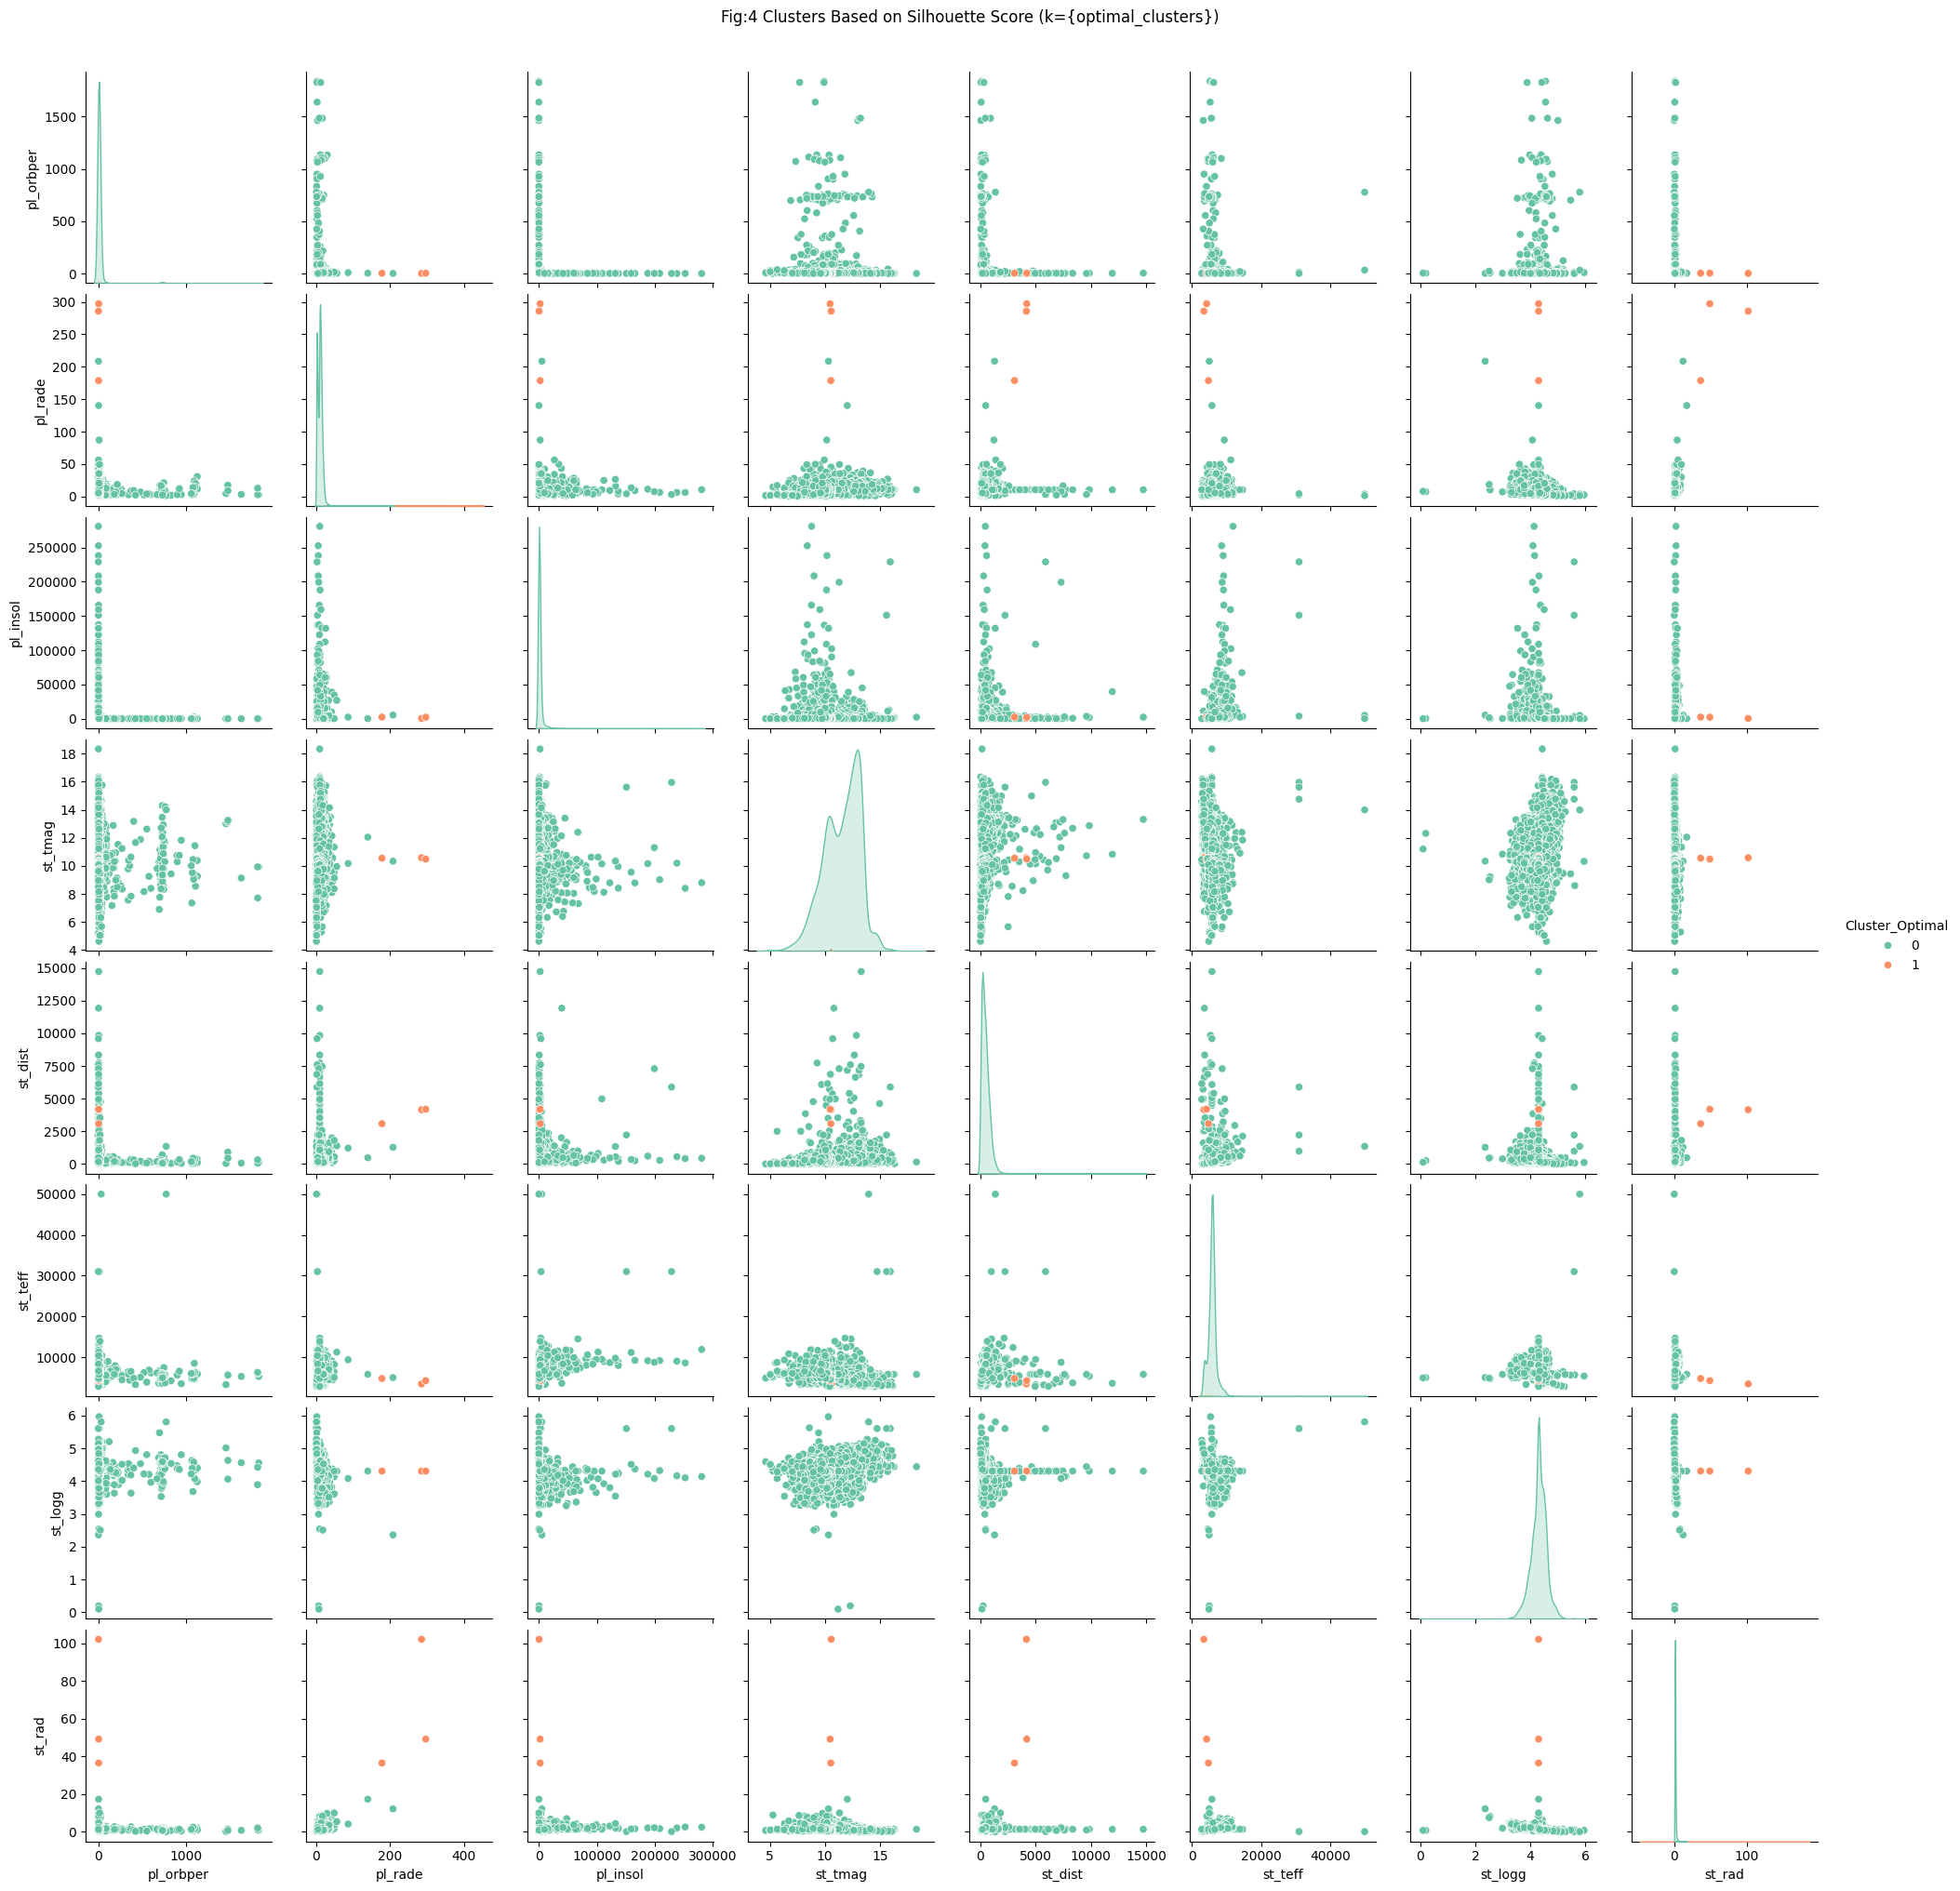

Fig:4 Cluster Sizes (Optimal Clusters):
 Cluster_Optimal
0    7355
1       3
Name: count, dtype: int64


In [7]:
from sklearn.metrics import silhouette_score

# List to store silhouette scores for different cluster numbers
sil_scores = []
range_n_clusters = range(2, 11)

# Calculate silhouette score for different cluster numbers
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Calculate the silhouette score
    score = silhouette_score(scaled_data, cluster_labels)
    sil_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title("Fig:3 Silhouette Score Method")
fig_count += 1
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Determine the optimal number of clusters based on the highest silhouette score
optimal_clusters = range_n_clusters[sil_scores.index(max(sil_scores))]
print(f"The optimal number of clusters is: {optimal_clusters}")

# Perform K-means with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster_Optimal'] = kmeans_optimal.fit_predict(scaled_data)

# Visualizing the clusters with the optimal number of clusters
sns.pairplot(df, vars=numeric_columns, hue='Cluster_Optimal', palette='Set2', diag_kind='kde')
plt.suptitle(f"Fig:" + str(fig_count) +" Clusters Based on Silhouette Score (k={optimal_clusters})", y=1.02)
fig_count += 1
plt.show()

# Summary of cluster sizes
print(f"Fig:4 Cluster Sizes (Optimal Clusters):\n", df['Cluster_Optimal'].value_counts())
fig_count += 1

# Save the clustered DataFrame
df.to_csv('clustered_data_optimal.csv', index=False)



It's interesting to see the Silhouette score go back up to about .217 around 6 clusters.

In [8]:
score_clusters(kmeans_optimal.labels_, scaled_data)

Silhouette Score: 0.9418
Davies-Bouldin Index: 0.4095
Silhouette Score indicates good separation between clusters.
Davies-Bouldin Index indicates well-formed clusters.


Cluster Assignments (labels_):
[1 1 1 ... 2 1 2]

Cluster Centers (cluster_centers_):
[[-0.12549824  0.30128179 -0.10957914  0.74573147  0.39525374 -0.0022378
  -0.06426093 -0.04268566]
 [-0.05194173  0.38921913  0.51663705 -0.82573997  0.02781526  0.79515241
  -1.03797617  0.61256409]
 [ 0.21054239 -0.66807004 -0.16166526 -0.55367859 -0.57962698 -0.48565988
   0.72958462 -0.31584247]]

Inertia (inertia_):
46321.581227641924


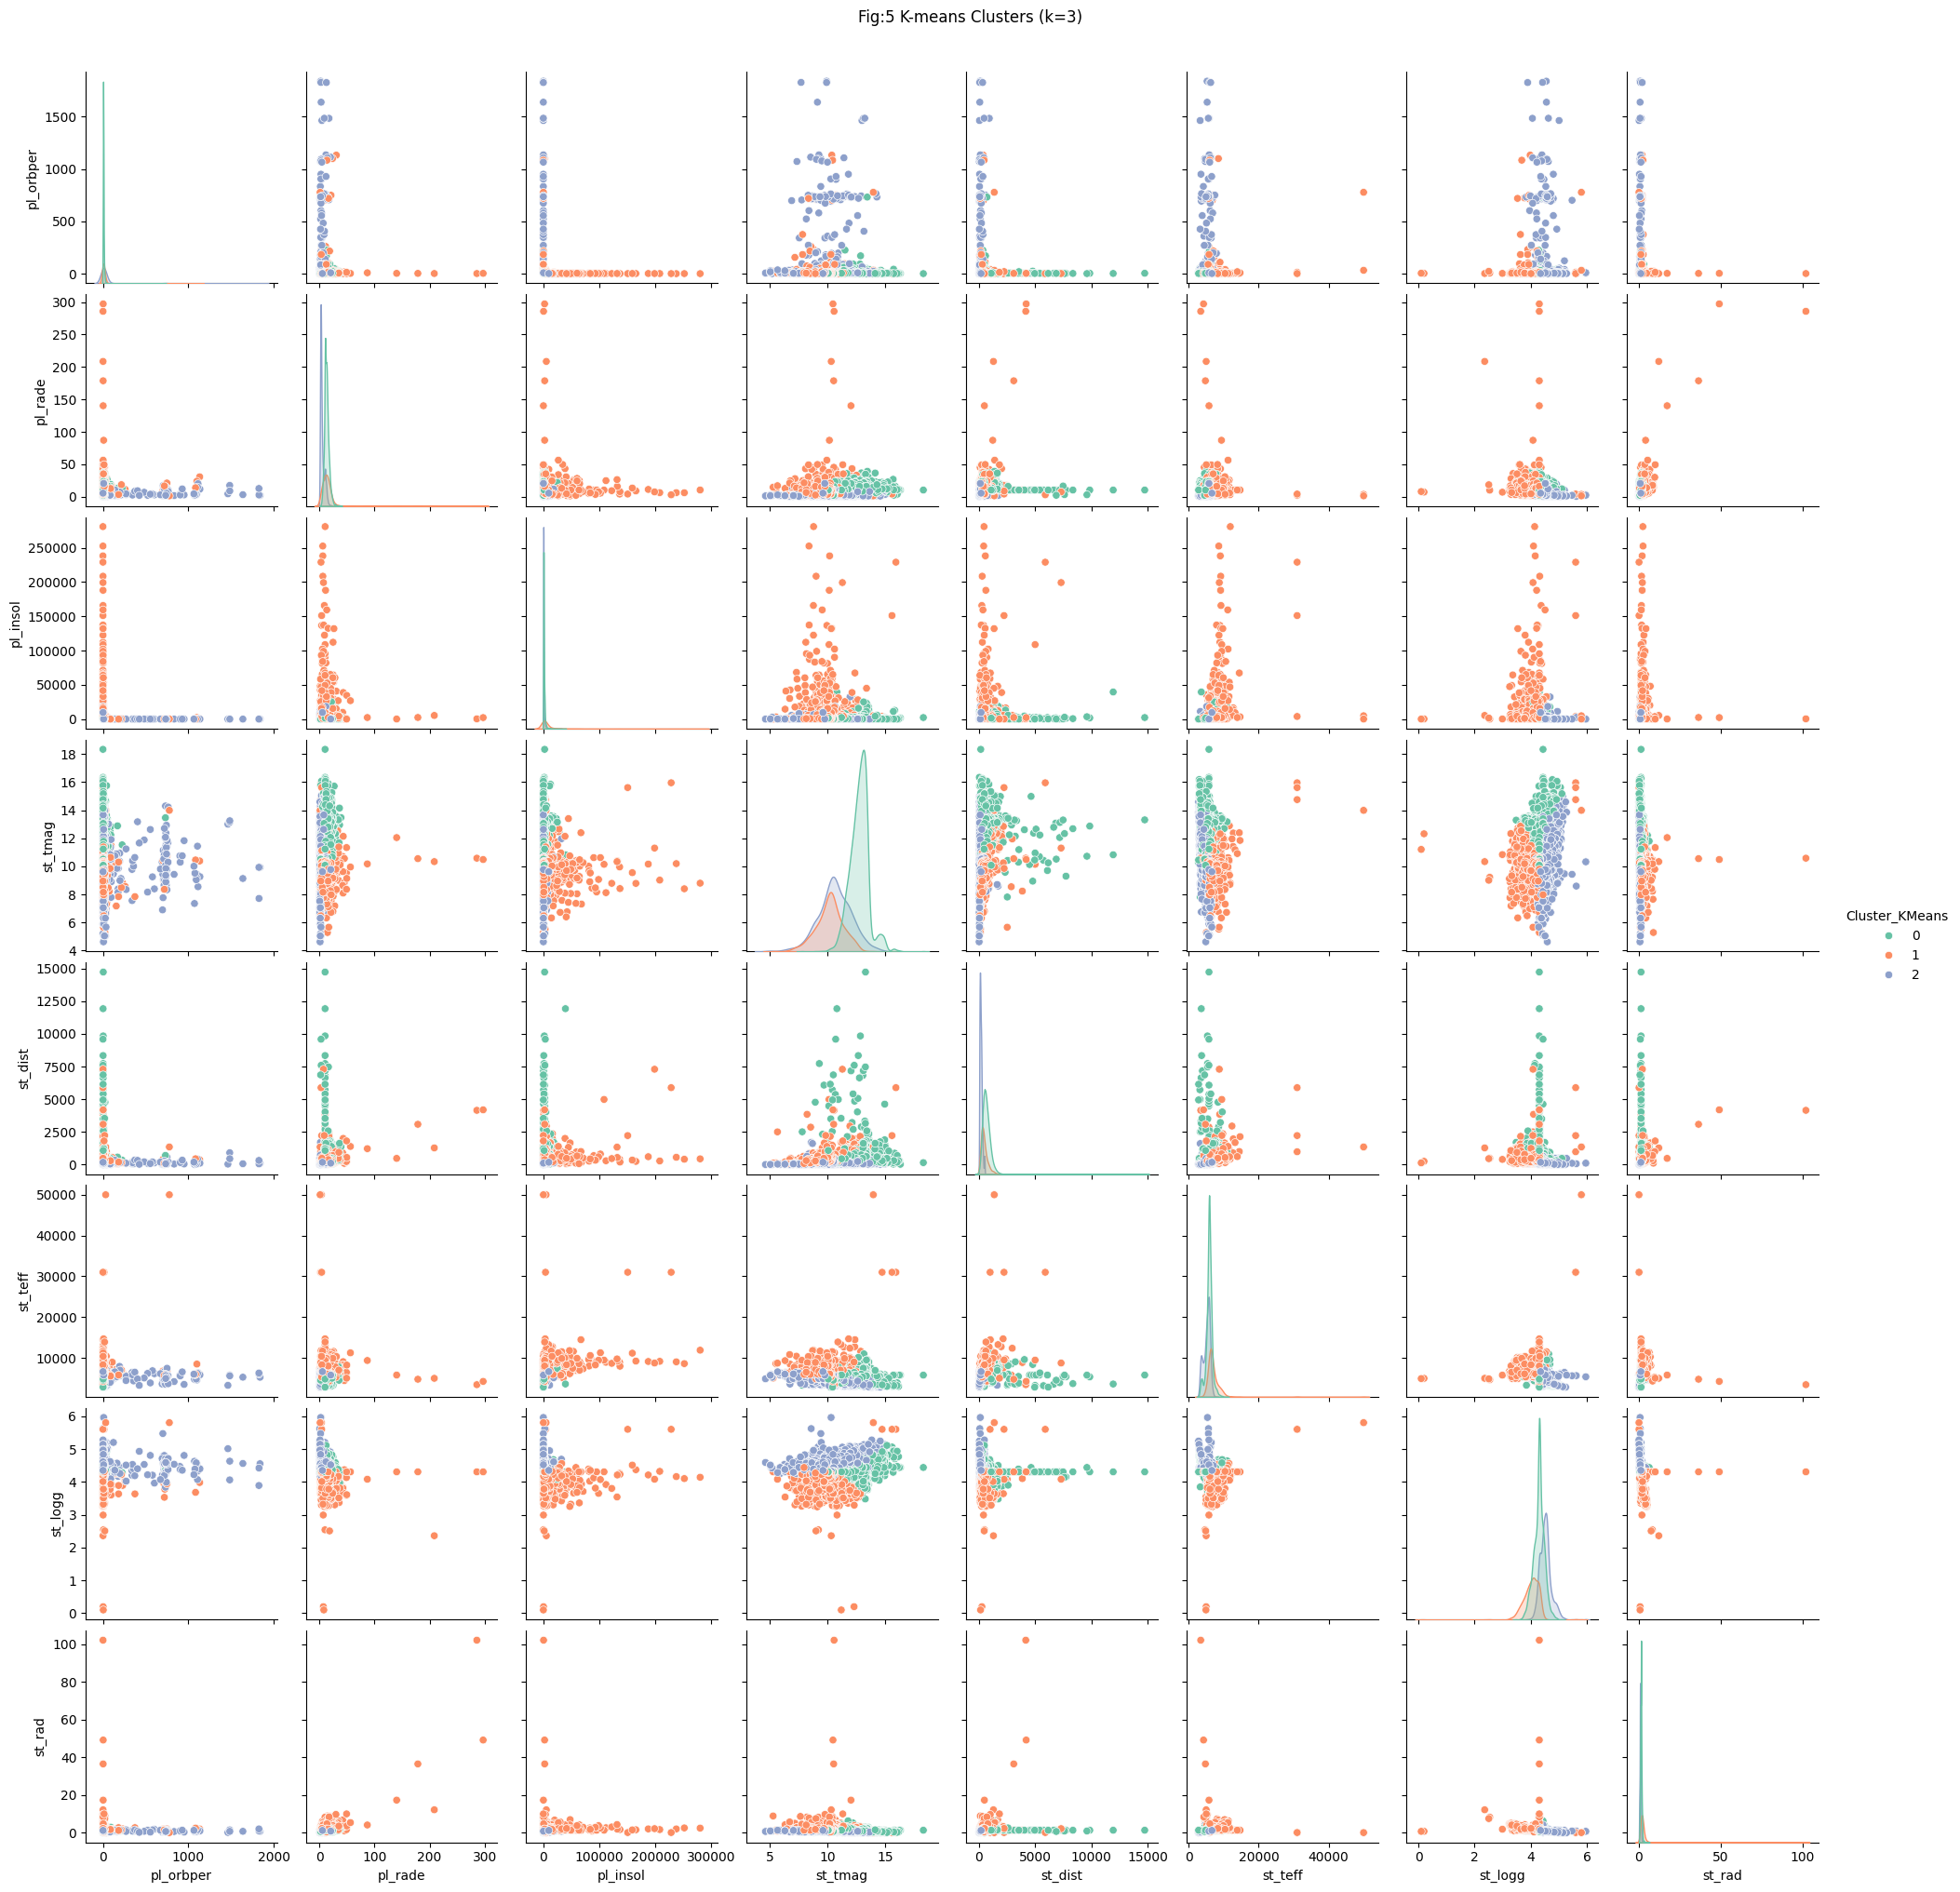

Cluster Sizes (K-means):
 Cluster_KMeans
0    3445
2    2419
1    1494
Name: count, dtype: int64


In [9]:
# Fit K-means with the optimal number of clusters (e.g., 3 clusters in this case)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# 1. Examine the labels_ (cluster assignments for each data point)
print("Cluster Assignments (labels_):")
print(kmeans.labels_)

# 2. Check the cluster centers (coordinates of the centroids)
print("\nCluster Centers (cluster_centers_):")
print(kmeans.cluster_centers_)

# 3. Review the inertia (sum of squared distances of samples to their cluster center)
print("\nInertia (inertia_):")
print(kmeans.inertia_)

# Add the cluster assignments to the DataFrame for further analysis
df['Cluster_KMeans'] = kmeans.labels_

# Visualizing the K-means clusters
sns.pairplot(df, vars=numeric_columns, hue='Cluster_KMeans', palette='Set2', diag_kind='kde')
plt.suptitle(f"Fig:5 K-means Clusters (k=3)", y=1.02)

plt.show()

# Summary of cluster sizes
print(f"Cluster Sizes (K-means):\n", df['Cluster_KMeans'].value_counts())

# Save the clustered DataFrame
df.to_csv('clustered_data_kmeans.csv', index=False)

In [10]:
score_clusters(kmeans.labels_, scaled_data)

Silhouette Score: 0.2432
Davies-Bouldin Index: 1.5556
Silhouette Score indicates moderate separation between clusters.
Davies-Bouldin Index suggests room for improvement in cluster quality.


Best GMM Result:
 n_components                                                     10
bic                                                    -6917.172446
aic                                                   -10016.863449
cluster_labels    [7, 7, 8, 0, 7, 5, 3, 3, 3, 0, 6, 7, 1, 7, 0, ...
Name: 9, dtype: object


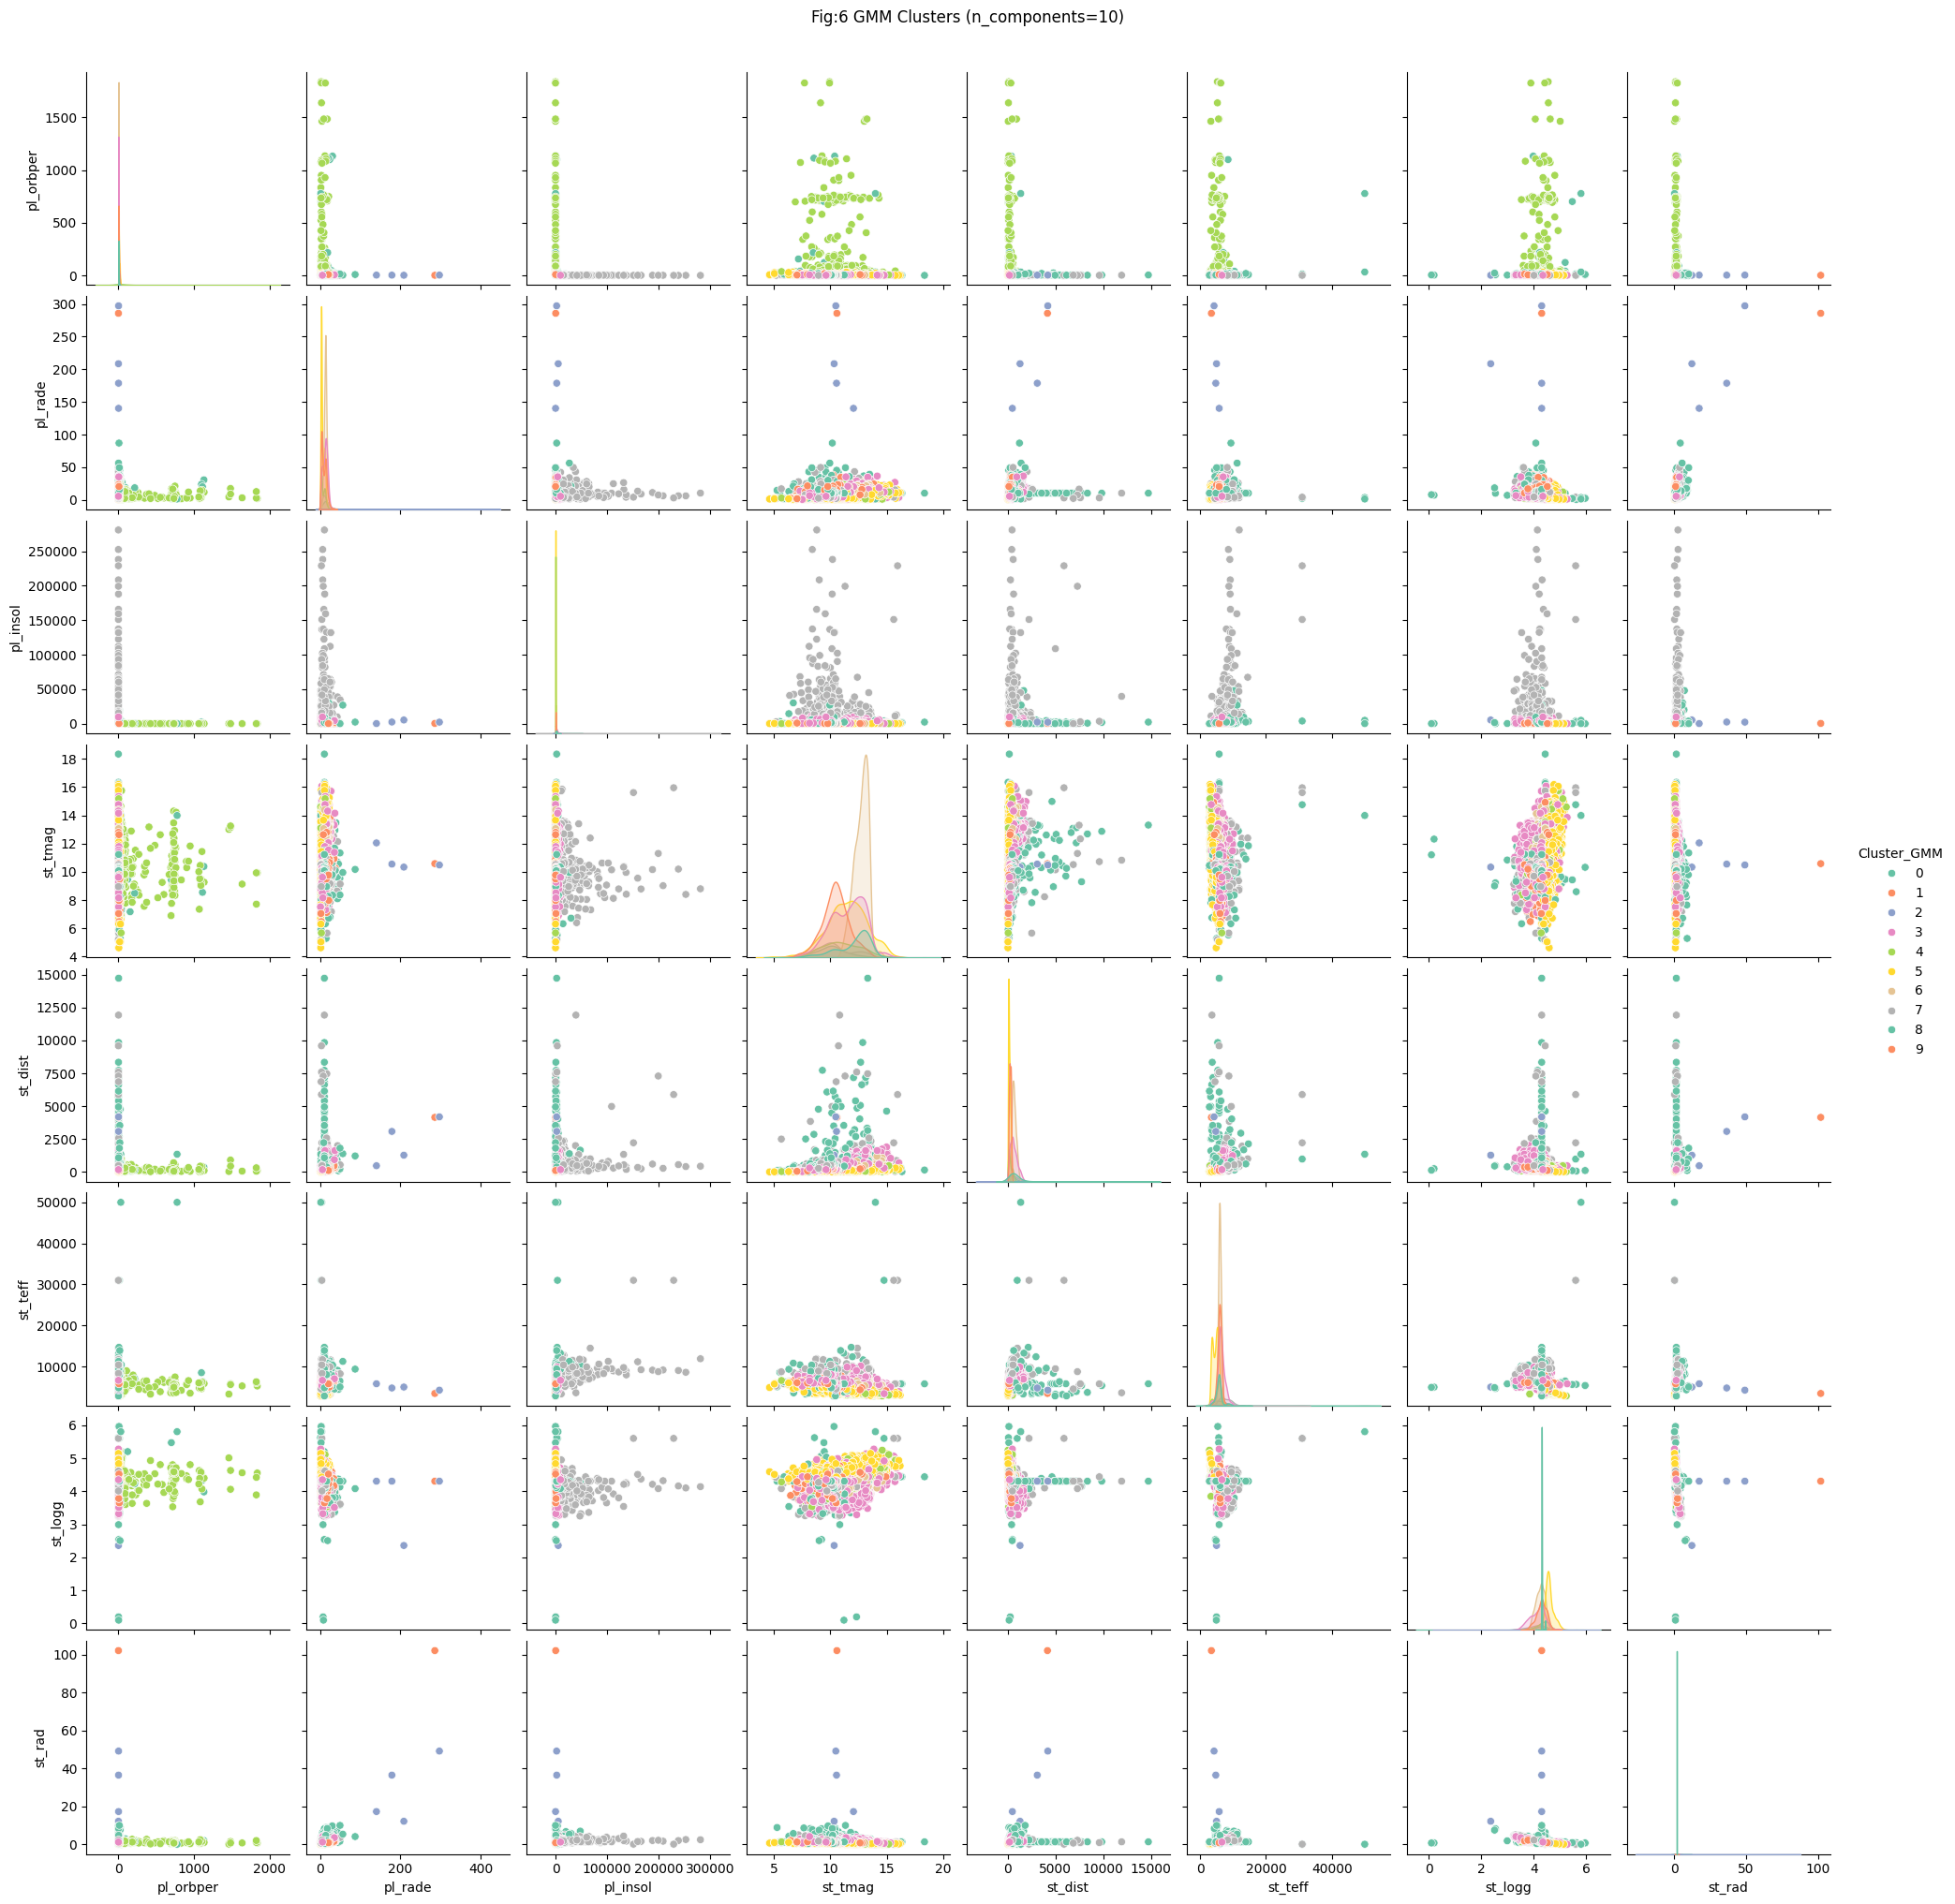

Cluster Sizes (GMM):
 Cluster_GMM
6    1783
5    1545
3    1412
1    1202
0     437
4     430
7     316
8     228
2       4
9       1
Name: count, dtype: int64


In [11]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Number of clusters (components) you want to try
n_components_range = range(1, 11)  # You can experiment with this range

# List to store results
gmm_results = []

for n_components in n_components_range:
    # Fit a Gaussian Mixture Model with n_components
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(scaled_data)

    # Predict the cluster labels
    cluster_labels = gmm.predict(scaled_data)

    # Store the results
    gmm_results.append({
        'n_components': n_components,
        'bic': gmm.bic(scaled_data),  # Bayesian Information Criterion
        'aic': gmm.aic(scaled_data),  # Akaike Information Criterion
        'cluster_labels': cluster_labels
    })

# Convert the results to a DataFrame for easy comparison
gmm_df = pd.DataFrame(gmm_results)

# Find the best number of components based on BIC or AIC
best_result = gmm_df.loc[gmm_df['bic'].idxmin()]  # Choose the model with the lowest BIC
print("Best GMM Result:\n", best_result)

# Apply the best GMM to the data
best_n_components = best_result['n_components']
best_gmm = GaussianMixture(n_components=best_n_components, random_state=42)
df['Cluster_GMM'] = best_gmm.fit_predict(scaled_data)

# Visualize the clusters (optional, pairplot is used here)
sns.pairplot(df, vars=numeric_columns, hue='Cluster_GMM', palette='Set2', diag_kind='kde')
plt.suptitle(f"Fig:6 GMM Clusters (n_components={best_n_components})", y=1.02)
fig_count += 1
plt.show()

# Summary of cluster sizes
print(f"Cluster Sizes (GMM):\n", df['Cluster_GMM'].value_counts())

# Save the clustered DataFrame
df.to_csv('clustered_data_gmm.csv', index=False)


In [12]:
score_clusters(df['Cluster_GMM'], scaled_data)


Silhouette Score: 0.0242
Davies-Bouldin Index: 2.2824
Silhouette Score indicates poor separation between clusters.
Davies-Bouldin Index suggests room for improvement in cluster quality.


   eps  min_samples  num_clusters  num_noise
0  0.5            5             8       1271
1  0.5           10             1       1562
2  0.5           20             1       1927
3  1.0            5             5        361
4  1.0           10             2        430
5  1.0           20             2        508
6  1.5            5             7        145
7  1.5           10             2        206
8  1.5           20             2        253
Best DBSCAN Result:
 eps                0.5
min_samples        5.0
num_clusters       8.0
num_noise       1271.0
Name: 0, dtype: float64


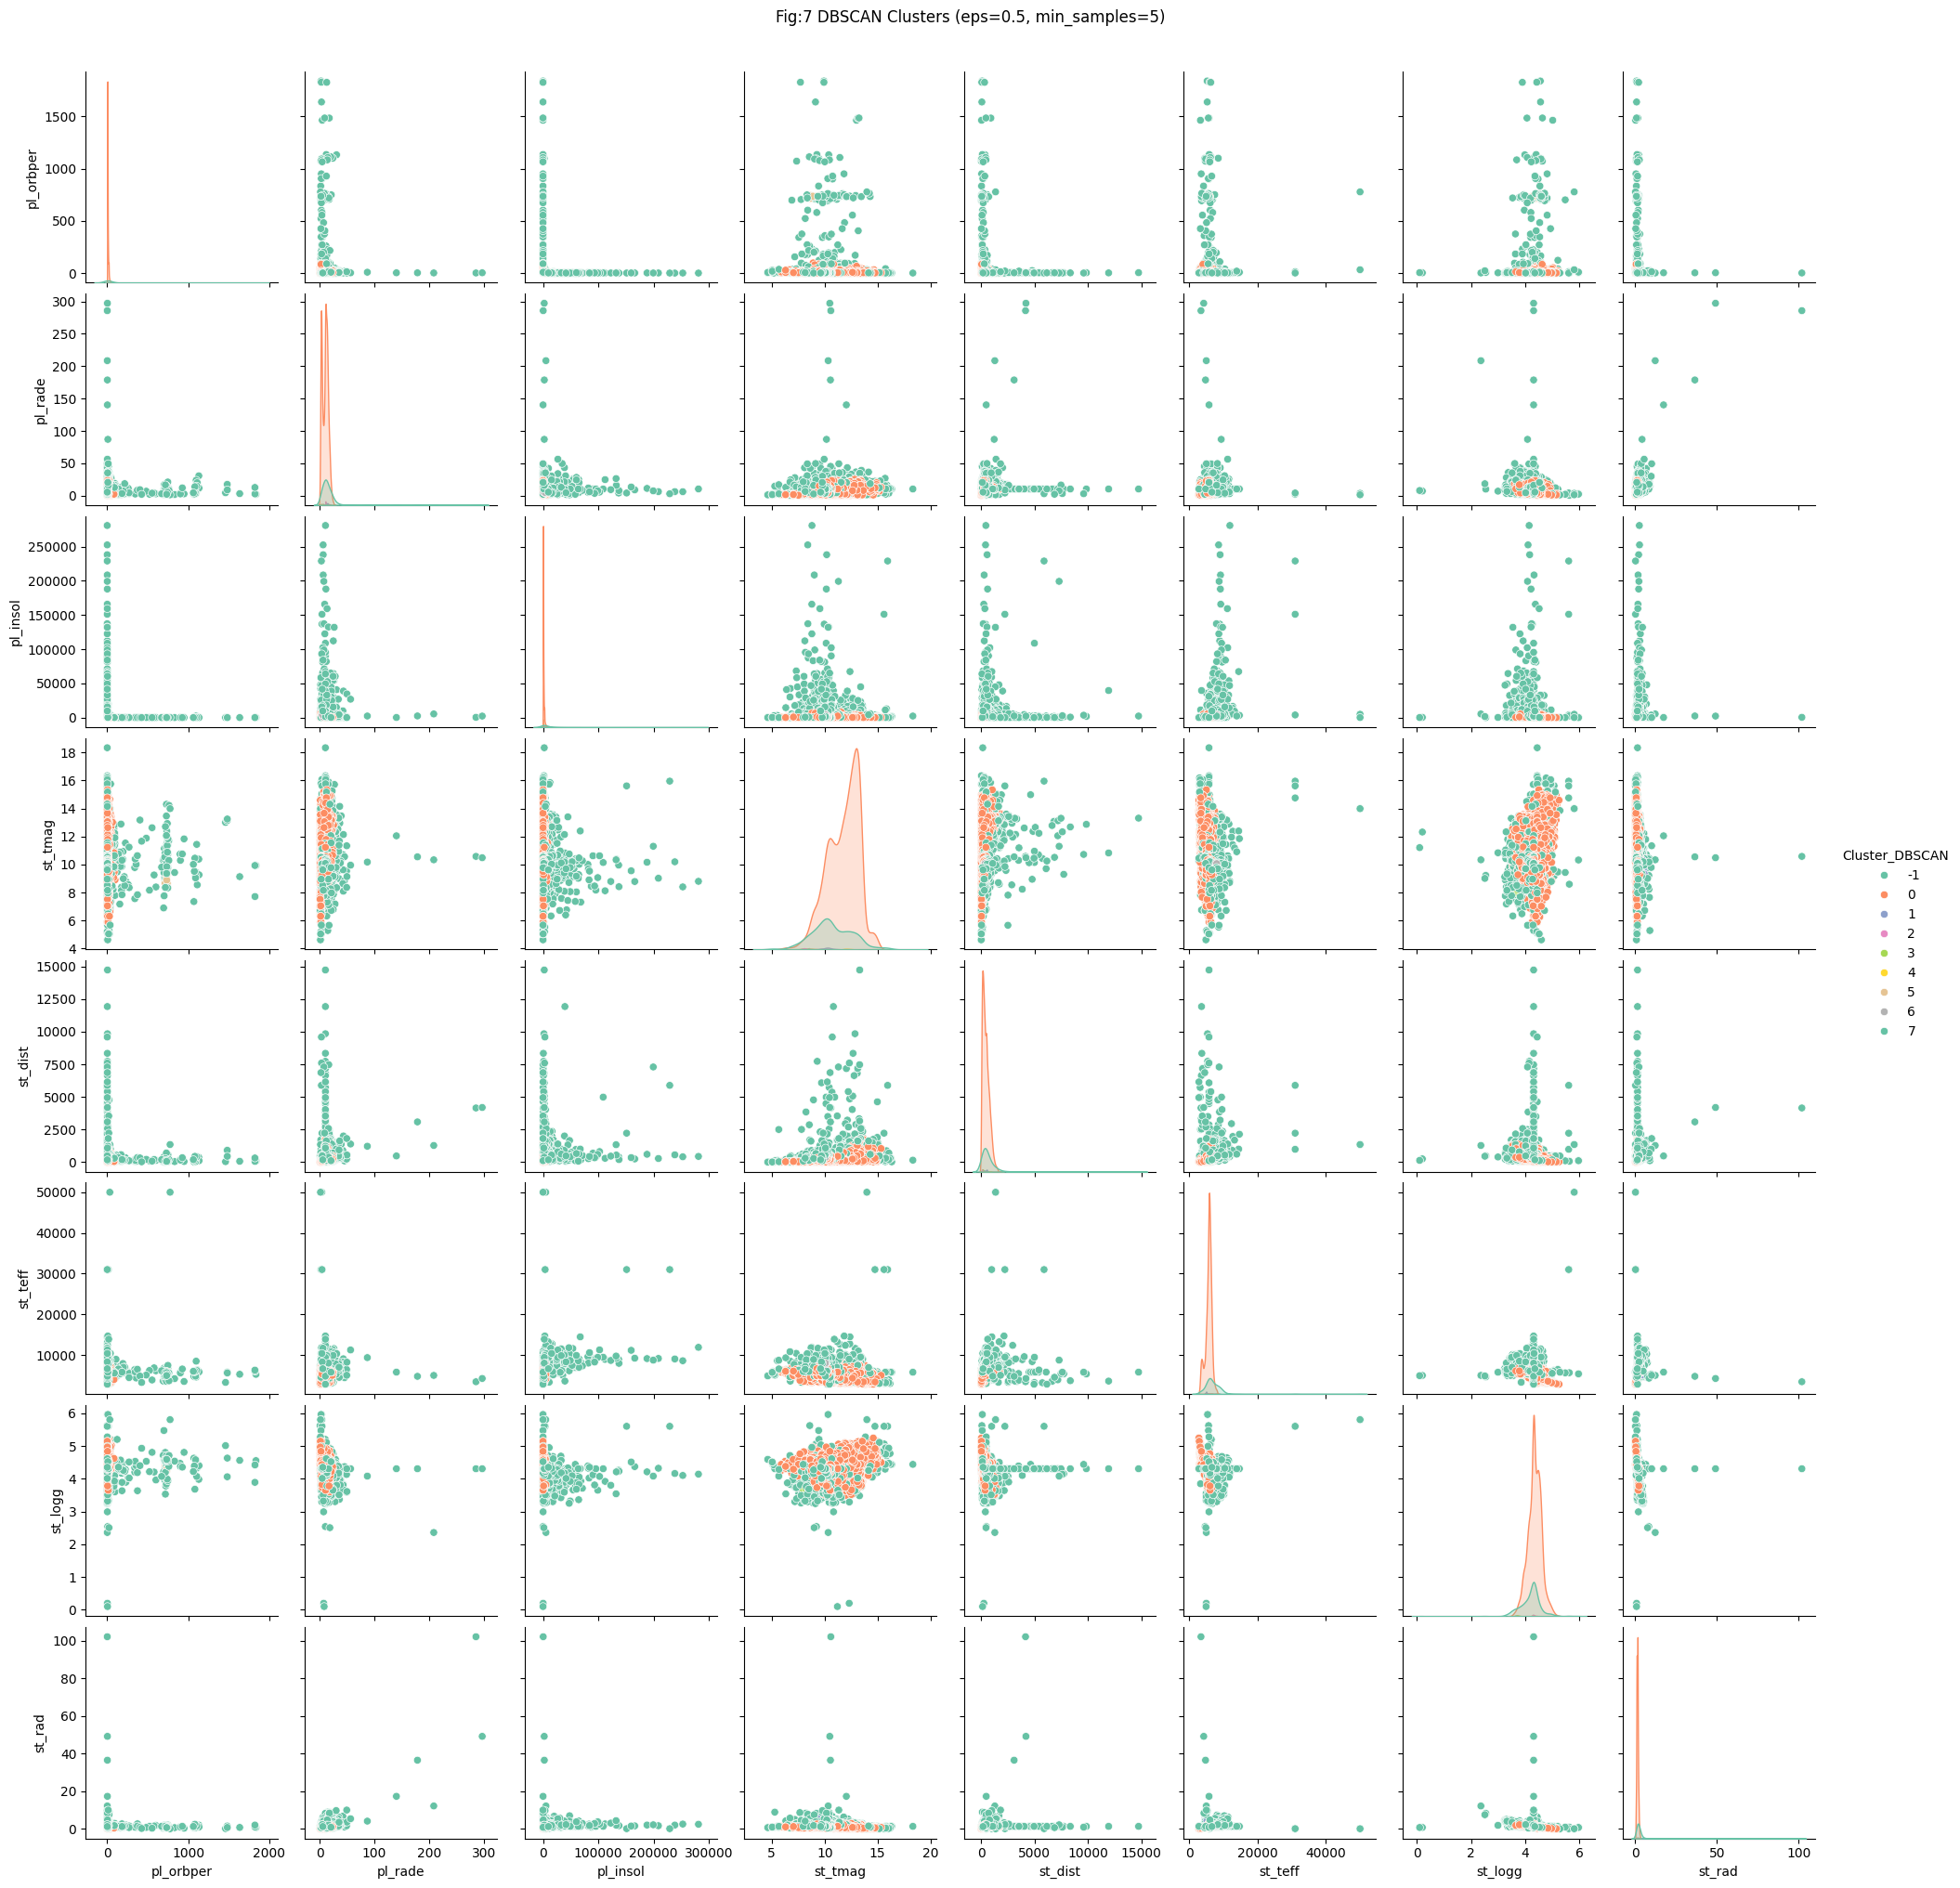

Cluster Sizes (DBSCAN):
 Cluster_DBSCAN
 0    6033
-1    1271
 1      18
 2       7
 3       7
 6       6
 5       6
 7       5
 4       5
Name: count, dtype: int64


In [13]:
from sklearn.cluster import DBSCAN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Experiment with different eps and min_samples values
eps_values = [0.5, 1.0, 1.5]  # Max distance for points to be considered neighbors
min_samples_values = [5, 10, 20]  # Minimum number of points required to form a dense region

# List to store clustering results
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(scaled_data)

        # Store the results (eps, min_samples, number of clusters, number of noise points)
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        num_noise = list(cluster_labels).count(-1)
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'num_clusters': num_clusters,
            'num_noise': num_noise
        })

# Convert results to DataFrame
dbscan_df = pd.DataFrame(dbscan_results)

# Display the results for different eps and min_samples values
print(dbscan_df)

# Select the best combination based on desired number of clusters or noise
# For now, we'll choose the first row with the maximum number of clusters
best_result = dbscan_df.loc[dbscan_df['num_clusters'].idxmax()]
print("Best DBSCAN Result:\n", best_result)

# Ensure min_samples is an integer
best_eps = best_result['eps']
best_min_samples = int(best_result['min_samples'])  # Fix: Convert to integer

# Apply DBSCAN with the best parameters
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df['Cluster_DBSCAN'] = dbscan_best.fit_predict(scaled_data)

# Visualize the clusters
sns.pairplot(df, vars=numeric_columns, hue='Cluster_DBSCAN', palette='Set2', diag_kind='kde')
plt.suptitle(f"Fig:7 DBSCAN Clusters (eps={best_eps}, min_samples={best_min_samples})", y=1.02)
fig_count += 1
plt.show()

# Summary of cluster sizes
print(f"Cluster Sizes (DBSCAN):\n", df['Cluster_DBSCAN'].value_counts())

# Save the clustered DataFrame
df.to_csv('clustered_data_dbscan.csv', index=False)

In [14]:
score_clusters(df['Cluster_DBSCAN'], scaled_data)

Silhouette Score: -0.2089
Davies-Bouldin Index: 1.8988
Silhouette Score indicates poor separation between clusters.
Davies-Bouldin Index suggests room for improvement in cluster quality.



Answer these questions at the bottom using markdown (one markdown cell per answer).
1. Which method did you like the most?
2. Which method did you like the least?
3. How did you score these unsupervised models?  
4. Did the output align with your geologic understanding?
5. What did you want to learn more about?
6. Did you pre-process your data?
7. What was a decision you were most unsure about?

## Which method did you like the most?


   I enjoy that we can specify the minimum samples in a cluster (`min_samples`). This allows us to define the smallest meaningful group, which is particularly helpful for filtering out noise or ensuring that clusters represent significant patterns.

   DBSCAN automatically labels outliers as noise points, which is useful in datasets with outliers. This makes it more flexible compared to methods like K-means, which can be heavily influenced by outliers.

   Unlike K-means or GMM, DBSCAN does not require the us to specify the number of clusters in advance. Instead, it identifies clusters based on density.

## Which method did you like the least?
K disliked the K-means method because I have to pick the cluster size, and that feels arbitrary in this problem space. However the method I liked the best DBScan seems to have scored pretty badly with poor separation between cluster and room for improvement in cluster quality.


# How did you score these unsupervised models?

All the models were scored using the Silhouette Score and the Davies-Bouldin Index. The Silhouette Score helps evaluate how well-separated the clusters are. The Davies-Bouldin Index assesses cluster quality, a lower values suggest more distinct and well-separated clusters. This approach allowed me to compare the performance of different clustering methods with the same measuring device.


## Did the output align with your geologic understanding?

I don't have much domain knowledge with this dataset so this question is difficult to answer. Most exoplanets are confirmed by a transit event. So when the exoplanet orbits their star, and the planets align so that from left to right it's Star -> exoplanet -> observer we can measure a decrease in the star's brightness because of the exoplanet blocking some of that light. It takes multiple transits to confirm that reduction in light, is a real planet, not a malfunction or mis-measurement.  

All of that to say, these other metrics might not be great features to track to see if something is an exoplanet or not, the clusters might be highlighting a different pattern or attribute that I don't understand yet.

### K-means - elbow
Silhouette Score: 0.2076
Davies-Bouldin Index: 1.6378

### K-means Silhouette
Silhouette Score: 0.2225
Davies-Bouldin Index: 1.8642

###  K-Means = 3
Silhouette Score: 0.2076
Davies-Bouldin Index: 1.6378

### GMM
Silhouette Score: -0.0130
Davies-Bouldin Index: 3.1529

### DBSCAN
Silhouette Score: -0.3247
Davies-Bouldin Index: 1.7648



## What did you want to learn more about?

I'd like to compare these clusters to confirmed planets to see if the clustering is similar.



## Did you pre-process your data?

Data was pre-processed by first handling any non-numeric columns. Afterward, I checked for and filled any missing values. Then the StandardScaler was used to ensure features with large numerical ranges were not over represented in the dataset.

# What was a decision you were most unsure about?

Guessing on the cluster size on K means, or the min cluser size on DBScan feels very wrong.